# take2

**GOAL**: Keep It Stupid Simple = KISS.

**Dependencies:**
 - [pocketknives](https://github.com/zjwilliams20/pocketknives)

**References:**
 1. [ilqgames/python](https://github.com/HJReachability/ilqgames/blob/master/python)

In [1]:
import itertools
import random
from time import perf_counter as pc

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.spatial.transform import Rotation
import sklearn.cluster as cluster
import torch

from decentralized import split_agents
import decentralized as dec
import pocketknives

π = np.pi

In [2]:
%load_ext autoreload
%autoreload 1
%aimport decentralized.control, decentralized.dynamics, decentralized.cost, decentralized.problem

In [3]:
%matplotlib widget
plt.rcParams['axes.grid'] = True

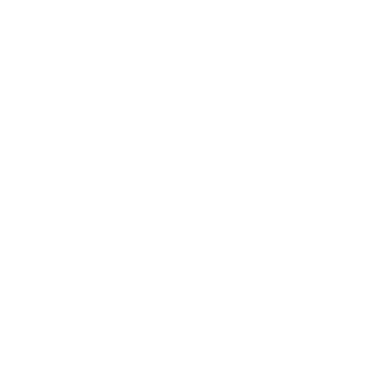

In [4]:
fig = plt.figure(figsize=(3.7, 3.7))

In [5]:
def pos_mask(x_dims):
    """Return a mask that's true wherever there's an x or y position""" 
    return np.array([i % x_dims[0] < 2 for i in range(sum(x_dims))])

In [6]:
def plot_solve(X, J, x_goal, x_dims=None):
    """Plot the resultant trajectory on plt.gcf()"""

    plt.clf()
    
    if not x_dims:
        x_dims = [X.shape[1]]
        
    N = X.shape[0]
    t = np.arange(N) * dt
    
    X_split = split_agents(X, x_dims)
    x_goal_split = split_agents(x_goal.reshape(1,-1), x_dims)
    
    for Xi, xg in zip(X_split, x_goal_split):
        plt.scatter(Xi[:,0], Xi[:,1], c=t)
        plt.scatter(Xi[0,0], Xi[0,1], 80, 'g', 'x', label="$x_0$")
        plt.scatter(xg[0,0], xg[0,1], 80, 'r', 'x', label="$x_f$")
    
    plt.margins(0.1)
    plt.title(f"Final Cost: {J:.3g}")
    plt.draw()

## single-agent problem

In [7]:
dt = 0.1
N = 50

x = torch.tensor([-10, 10, 0], dtype=torch.float, requires_grad=True)
x_goal = torch.zeros((3, 1), dtype=torch.float).T

dynamics = dec.CarDynamics3D(dt)

Q = torch.diag(torch.tensor([1., 1, 0]))
Qf = 1000 * torch.eye(Q.shape[0])
R = torch.eye(2)
cost = dec.ReferenceCost(x_goal, Q, R, Qf)

prob = dec.ilqrProblem(dynamics, cost)
ilqr = dec.iLQR(prob, x.numel(), 2, dt, N)
X, U, J = ilqr.solve(x)
plot_solve(X, J, x_goal.numpy())

0/50	J: 210000
1/50	J: 106051	μ: 0.5	Δ: 0.5
2/50	J: 4572.96	μ: 0.125	Δ: 0.25
3/50	J: 2783.66	μ: 0.015625	Δ: 0.125
4/50	J: 2511.76	μ: 0.000976562	Δ: 0.0625
5/50	J: 2329.04	μ: 3.05176e-05	Δ: 0.03125
6/50	J: 2322.72	μ: 0	Δ: 0.015625
7/50	J: 2271.32	μ: 0	Δ: 0.0078125
8/50	J: 2261.2	μ: 0	Δ: 0.00390625
9/50	J: 2258.84	μ: 0	Δ: 0.00195312


## multi-agent problem

### initializing the scene
Here, we define some initial positions within some distance of each other, and then rotate them about the origin by some random angle to hopefully create some interesting scenarios.

In [8]:
def randomize_locs(n_pts, min_sep=3.0, var=3.0, n_dim=2):
    """Uniformly randomize locations of points in N-D while enforcing
       a minimum separation between them.
    """ 
    
    # Distance to move away from center if we're too close.
    Δ = 0.1 * n_pts
    x = var * np.random.uniform(-1, 1, (n_pts, n_dim))
    
    # Determine the pair-wise indicies for an arbitrary number of agents.
    pair_inds = np.array(list(itertools.combinations(range(n_pts), 2)))
    move_inds = np.arange(n_pts)

    # Keep moving points away from center until we satisfy radius
    while move_inds.size:
        center = np.mean(x, axis=0)
        distances = dec.compute_pairwise_distance(x.flatten(), [n_dim]*n_pts)

        move_inds = pair_inds[distances.flatten() <= min_sep]
        x[move_inds] += Δ * (x[move_inds] - center)
    
    return x

def face_goal(x0, x_goal):
    """Make the agents face the direction of their goal with a little noise"""
    
    VAR = 0.01
    dX = x_goal[:,:2] - x0[:,:2]
    headings = np.arctan2(*np.rot90(dX, 1))
    
    x0[:,2] = headings + VAR * np.random.randn(x0.shape[0])
    x_goal[:,2] = headings + VAR * np.random.randn(x0.shape[0])
    
    return x0, x_goal

def random_setup(n_agents, n_states, **kwargs):
    """Create a randomized set up of initial and final positions"""
    
    # Rotate the initial points by some amount about the center.
    theta = π + random.uniform(-π/4, π/4)
    R = Rotation.from_euler('z', theta).as_matrix()[:2, :2]

    # We don't have to normlize for energy here
    x_i = randomize_locs(n_agents, **kwargs)
    # x_f = x_i @ R + x_i.mean(axis=0)
    x_f = randomize_locs(n_agents, **kwargs)

    x0 = np.c_[x_i, np.zeros((n_agents, n_states-2))]
    x_goal = np.c_[x_f, np.zeros((n_agents, n_states-2))]
    x0, x_goal = face_goal(x0, x_goal)
    
    x0 = torch.from_numpy(x0).requires_grad_(True).type(torch.float)
    x_goal = torch.from_numpy(x_goal).type(torch.float)
    
    return x0.reshape(-1,1), x_goal.reshape(-1,1)

In [9]:
def paper_setup():
    """Hardcoded example with reasonable consistency eyeballed from 
       Potential-iLQR paper
    """
    x0 = torch.tensor([[0.5, 1.5, 0.1, 0,
                        2.5, 1.5, π, 0,
                        1.5, 1.3, π/2, 0]], 
                     dtype=torch.float, requires_grad=True).T
    x_goal = torch.tensor([[2.5, 1.5, 0, 0, 
                            0.5, 1.5, π, 0, 
                            1.5, 2.2, π/2, 0]]).T
    return x0, x_goal

def car_setup():
    """Same as paper_setup but using car dynamics"""
    x0, x_goal = paper_setup()
    car_mask = [i % 4 < 3 for i in range(x0.shape[0])]
    return x0[car_mask], x_goal[car_mask]

def bike_setup():
    """Same as paper_setup but using bike dynamics"""
    N_AGENTS = 3
    N_STATES = 5
    n_total_states = N_AGENTS * N_STATES
    bike_mask = [i % 5 < 4 for i in range(n_total_states)]
    
    x0, x_goal = paper_setup()
    x0_bike = torch.zeros(n_total_states, 1)
    x_goal_bike = torch.zeros_like(x0_bike)
    x0_bike[bike_mask] = x0
    x_goal_bike[bike_mask] = x_goal
    
    return x0_bike, x_goal_bike

def double_int_setup():
    x0, x_goal = paper_setup()
    theta_mask = [i % 4 == 2 for i in range(x0.shape[0])]
    with torch.no_grad():
        x0[theta_mask] = 0.0
        x_goal[theta_mask] = 0.0

    return x0, x_goal

def dec_test_setup():
    x0, x_goal = paper_setup()
    x0_other = torch.tensor([[5, 5, 0, 0,
                              6, 6, π/4, 0]]).T
    x_goal_other = torch.tensor([[6, 4, -π/2, 0,
                                  4, 6, π/4, 0]]).T
    
    x0 = torch.cat([x0, x0_other]) 
    x_goal = torch.cat([x_goal, x_goal_other])    
    
    return x0, x_goal

To be consistent between simulations, we normalize for the scale of the setup by computing the *energy*, or the sum of distances from the origin of the points. This should be the same for all runs.

In [10]:
def compute_energy(x, x_dims):
    """Determine the sum of distances from the origin"""
    return torch.sum(x[pos_mask(x_dims)].reshape(-1,2).norm(dim=1)).item()

def normalize_energy(x, x_dims, energy=10.0):
    """Zero-center the coordinates and then ensure the sum of 
       squared distances == energy
    """
    
    # Don't mutate x's data for this function, keep it pure.
    x = x.clone()
    n_agents = len(x_dims)
    center = x[pos_mask(x_dims)].reshape(-1, 2).mean(0)

    with torch.no_grad():
        x[pos_mask(x_dims)] -= center.tile(n_agents).reshape(-1,1)
        x[pos_mask(x_dims)] *= energy / compute_energy(x, x_dims)
    assert x.numel() == sum(x_dims)
    
    return x

def perturb_state(x, x_dims, var=0.5):
    """Add a little noise to the start to knock off perfect symmetries"""
    
    x = x.clone()
    with torch.no_grad():
        x[pos_mask(x_dims)] += var*torch.randn_like(x[pos_mask(x_dims)])
    
    return x

In [11]:
n_agents = 5
n_states = 4
ENERGY = 10.0

# x0, x_goal = paper_setup()
# x0, x_goal = car_setup()
# x0, x_goal = bike_setup()
# x0, x_goal = double_int_setup()
# x0, x_goal = dec_test_setup()
x0, x_goal = random_setup(n_agents, n_states, min_sep=1.0, var=1.0)

x_dims = [n_states] * n_agents
u_dims = [2] * n_agents

x0 = normalize_energy(x0, x_dims, ENERGY)
x_goal = normalize_energy(x_goal, x_dims, ENERGY)
# x0 = perturb_state(x0, x_dims)

plt.clf()
plt.gca().set_aspect('equal')
X = torch.dstack([
    x0.reshape(n_agents, n_states).detach(), 
    x_goal.reshape(n_agents, n_states).detach()
]).swapaxes(1,2)
for i, Xi in enumerate(X):
    plt.annotate('', Xi[1,:2], Xi[0,:2], 
                 arrowprops=dict(facecolor=plt.cm.tab20.colors[2*i]))
pocketknives.set_bounds(X.reshape(-1, n_states), zoom=0.2)
plt.draw()

(tensor([[ 2.0003, -1.1773, -0.5758,  0.0000]]),
 tensor([[-1.3490, -0.3809, -1.8913,  0.0000]]),
 tensor([[-1.5369,  2.1110,  3.0290,  0.0000]]),
 tensor([[0.8338, 1.4446, 0.9968, 0.0000]]),
 tensor([[ 0.0518, -1.9974, -2.0608,  0.0000]]))

In [35]:
dt = 0.05
N = 50
tol = 1e-3

model = dec.UnicycleDynamics4D(dt)
# model = dec.CarDynamics3D(dt)
# model = dec.BikeDynamics5D(dt)
# model = dec.DoubleIntDynamics4D(dt)
dynamics = dec.MultiDynamicalModel([model] * n_agents)

Q = 4 * torch.diag(torch.tensor([1., 1, 0, 0]))
# Qf = 1000 * torch.eye(Q.shape[0])
Qf = 1000 * torch.diag(torch.tensor([1., 1, 1, 1]))
R = torch.eye(2)

# radius = ENERGY / 20
radius = 0.5

goal_costs = [dec.ReferenceCost(x_goal_i, Q.clone(), R.clone(), Qf.clone()) 
              for x_goal_i in split_agents(x_goal.T, x_dims)] 
prox_cost = dec.ProximityCost(x_dims, radius)
game_cost = dec.GameCost(goal_costs, prox_cost)

prob = dec.ilqrProblem(dynamics, game_cost)

In [ ]:
%%time
# %%prun
ilqr = dec.iLQR(prob, x0.numel(), 2*n_agents, dt, N)
t0 = pc()
X, U, J = ilqr.solve(x0, tol=tol)

# t_solve = pc() - t0
# with open('out.log', 'a') as file:
#     file.write(f"{type(ilqr)}\t{t_solve=:.8g}\t{J=:.8g}\n")

In [37]:
%debug

> /home/zjw/documents/grad/Research/decentralized/decentralized/cost.py(84)__call__()
     82         if not terminal:
     83             # NOTE: u.T does nothing here since it will always come in flat.
---> 84             return (x - self.xf) @ self.Q @ (x - self.xf).T + u @ self.R @ u
     85         return (x - self.xf) @ self.Qf @ (x - self.xf).T
     86 



ipdb>  p x


tensor([[-2.4207,  1.1548, -0.5897,  0.0000]],
       grad_fn=<SplitWithSizesBackward0>)


ipdb>  self.xf


tensor([[ 2.0003, -1.1773, -0.5758,  0.0000]])


ipdb>  self.Q


tensor([[4., 0., 0., 0.],
        [0., 4., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])


ipdb>  p u


tensor([[0., 0.]])


ipdb>  q


In [14]:
plot_solve(X, J, x_goal.numpy(), x_dims)

In [15]:
plt.clf()
plt.plot(dec.compute_pairwise_distance(X, x_dims).T)
plt.hlines(radius, *plt.xlim(), 'r', ls='--')
plt.draw()

In [16]:
costs = []
for xi, ui in zip(X, U):
    costs.append(game_cost(xi, ui).item())
plt.clf()
plt.plot(costs)
plt.draw()

## multi-agent receding horizon

In [21]:
rhc = dec.RecedingHorizonController(x0, ilqr, step_size=10)
U0 = torch.zeros((ilqr.N, ilqr.n_u))
for Xi, Ui, Ji in rhc.solve(U0, J_converge=10.0, tol=tol):
    plot_solve(Xi, Ji, x_goal.numpy(), x_dims)
    fig.canvas.draw()

--------------------------------------------------
Horizon 0
0/50	J: 72026.2
1/50	J: 7106.57	μ: 0.5	Δ: 0.5
2/50	J: 5950.51	μ: 0.125	Δ: 0.25
3/50	J: 5754.99	μ: 0.015625	Δ: 0.125
4/50	J: 5697.05	μ: 0.000976562	Δ: 0.0625
5/50	J: 5378.5	μ: 3.05176e-05	Δ: 0.03125
6/50	J: 5319.07	μ: 0	Δ: 0.015625
7/50	J: 5259.66	μ: 0	Δ: 0.0078125
--------------------------------------------------
Horizon 1
0/50	J: 2076.29
1/50	J: 2031.51	μ: 0.5	Δ: 0.5
--------------------------------------------------
Horizon 2
0/50	J: 777.361
1/50	J: 769.109	μ: 0.5	Δ: 0.5
--------------------------------------------------
Horizon 3
0/50	J: 293.915
1/50	J: 285.922	μ: 0.5	Δ: 0.5
--------------------------------------------------
Horizon 4
0/50	J: 97.1659
1/50	J: 91.2521	μ: 0.5	Δ: 0.5
--------------------------------------------------
Horizon 5
0/50	J: 33.5255
1/50	J: 30.7283	μ: 0.5	Δ: 0.5
--------------------------------------------------
Horizon 6
0/50	J: 12.3762
1/50	J: 11.394	μ: 0.5	Δ: 0.5
---------------------------------

## decentralized multi-agent receding horizon

In [19]:
thresh_graph = dec.define_inter_graph_threshold(X, n_agents, radius, x_dims)
thresh_graph

{0: {0, 1, 2},
 1: {0, 1, 2, 3, 4},
 2: {0, 1, 2, 3, 4},
 3: {1, 2, 3, 4},
 4: {1, 2, 3, 4}}

## animation

In [166]:
def setup(X, x_goal, x_dims, radius):
    plt.clf()
    
    n_agents = len(x_dims)
    ax = plt.gca()
    handles = []
    for i in range(n_agents):
        handles.append((
            plt.plot(0, c=plt.cm.tab20.colors[2*i], marker='o', markersize=4)[0],
            ax.add_artist(plt.Circle(np.nan, radius, color='k', fill=True, alpha=0.3, lw=2))
        ))
        
    for xg in split_agents(x_goal, x_dims):
        plt.scatter(xg[0,0], xg[0,1], c='r', marker='x', zorder=10)

    X_cat = np.vstack(split_agents(X, x_dims))
    pocketknives.set_bounds(X_cat, zoom=0.3)
    plt.draw()
    
    return handles
    
def animate(t, handles, X, x_dims, x_goal):
    """Animate the solution into a gif"""
    for (i, xi), hi in zip(enumerate(split_agents(X, x_dims)), handles):
        hi[0].set_xdata(xi[:t,0])
        hi[0].set_ydata(xi[:t,1])
        hi[1].set_center(xi[t-1,:2])
    plt.draw()
    

In [175]:
plt.clf()
handles = setup(X, x_goal.flatten(), x_dims, radius)
animate(-1, handles, X, x_dims, x_goal)

In [55]:
handles = setup(X, x_goal.flatten(), x_dims, radius)
anim = FuncAnimation(plt.gcf(), animate, frames=N+1, fargs=(handles, X, x_dims, x_goal))
anim.save('traj.gif', fps=5)

MovieWriter ffmpeg unavailable; using Pillow instead.
